In [1]:
import os
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation

from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort, MeldSubject

from meld_graph.evaluation import Evaluator
import numpy as np
import matplotlib.pyplot as plt 




Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


In [3]:
save_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/23-00-01_TEST_plot_saliencies'


In [12]:
# load experiment
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-08-18_IFYF_object_save_final/s_0/fold_all'
exp = meld_graph.experiment.Experiment.from_folder(model_path)
exp.data_parameters["augment_data"] = {}

#load trainval dataset
split = "trainval"

save_prediction_suffix=""

# subjects = exp.data_parameters["train_ids"] + exp.data_parameters["val_ids"]
subjects= [
        # 'MELD_H14_3T_FCD_0019', 
           'MELD_H14_3T_FCD_0017',
        #    'MELD_H23_15T_FCD_0007',
           ]

features = exp.data_parameters["features"]
cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )
dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode="test")
    
# create evaluator
eva = Evaluator(
    experiment=exp,
    checkpoint_path=model_path,
    make_images=False,
    dataset=dataset,
    cohort=cohort,
    save_dir=save_dir,
    subject_ids=subjects,
    mode="test",
    thresh_and_clust=False,
)


Initialised Experiment 23-08-18_IFYF_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-08-18_IFYF_object_save_final/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H14_3T_FCD_0017
Creating model
Predicting model without dropout


In [10]:
# calculate saliencies if not already available
saliencies = eva.calculate_saliency()

calculating saliency
Loading and preprocessing test data
Z-scoring data for MELD_H14_3T_FCD_0017
calculating saliency for MELD_H14_3T_FCD_0017, cluster 1.0
saving saliencies_1.0 for MELD_H14_3T_FCD_0017


## plot saliencies vertices

In [7]:
subject_id = 'MELD_H14_3T_FCD_0017'
cluster = 1.0
hemi='left'

#load predictions and labels 
data = eva.load_data_from_file(subject_id, keys=['cluster_thresholded','input_labels', 'saliencies_1.0'], split_hemis=True, save_prediction_suffix="")
predictions = data['cluster_thresholded'][hemi]
mask_clust= (predictions==cluster)
labels = data['input_labels'][hemi].numpy()
saliencies = data['saliencies_1.0'][hemi]

Loading and preprocessing test data
Z-scoring data for MELD_H14_3T_FCD_0017


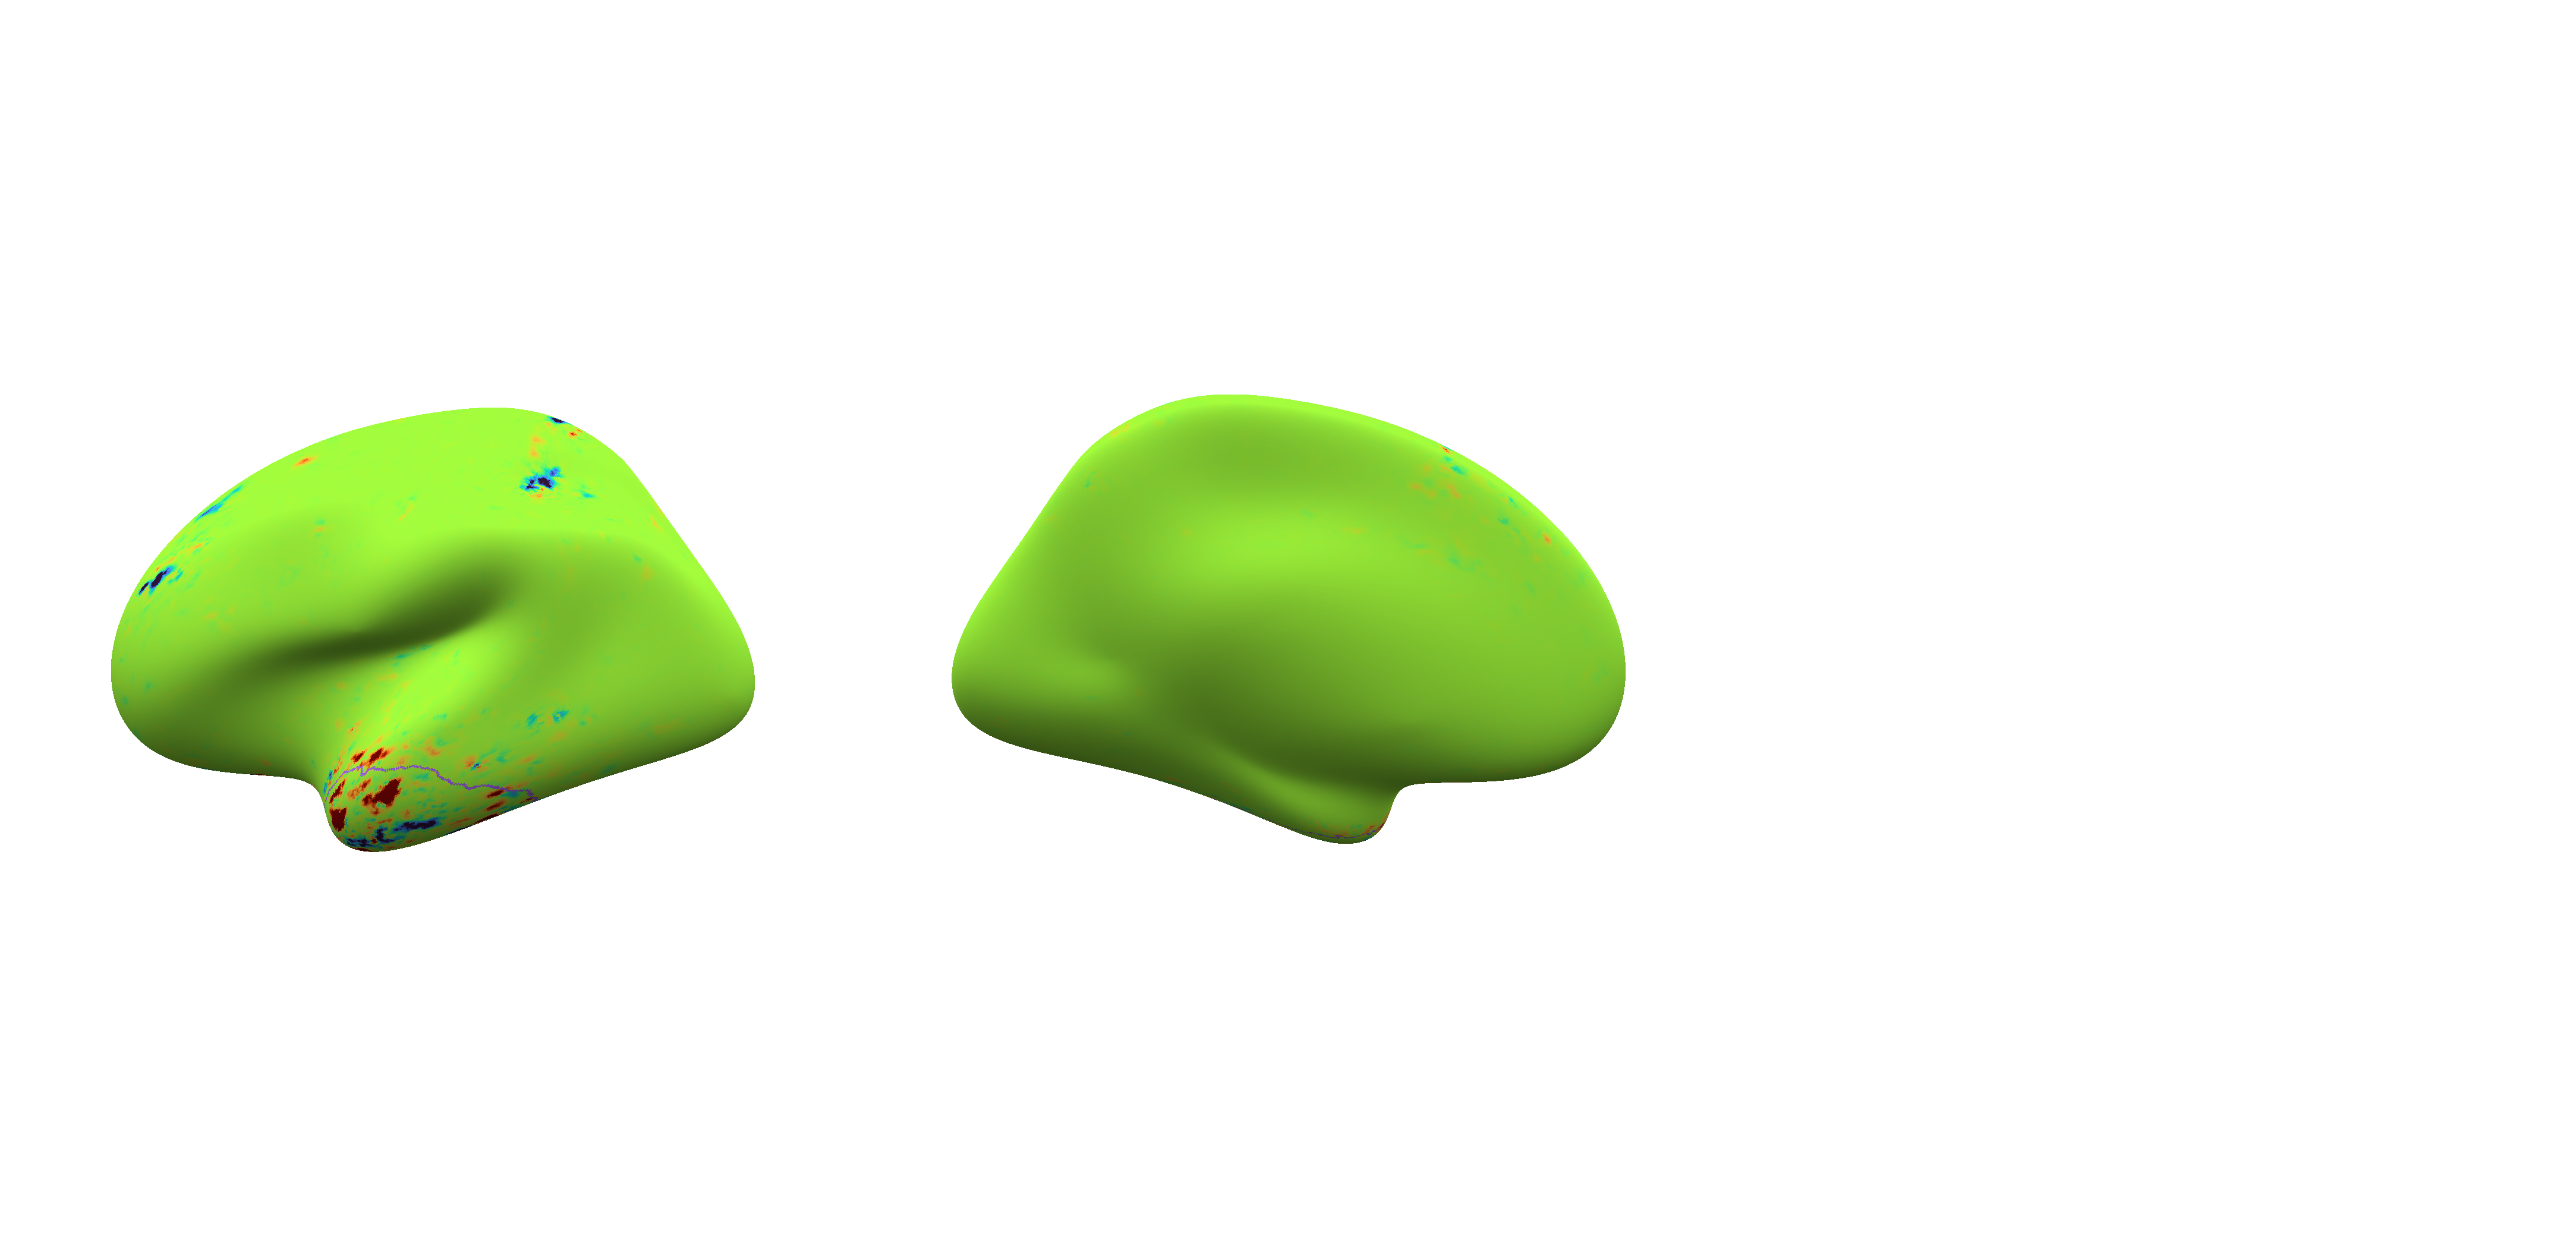

In [39]:
# plot saliencies for a feature
import matplotlib_surface_plotting as msp
feature = '.inter_z.asym.intra_z.combat.on_lh.sulc.sm3.mgh'
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], saliencies[:,features.index(feature)],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5, parcel = mask_clust,
    )

6681


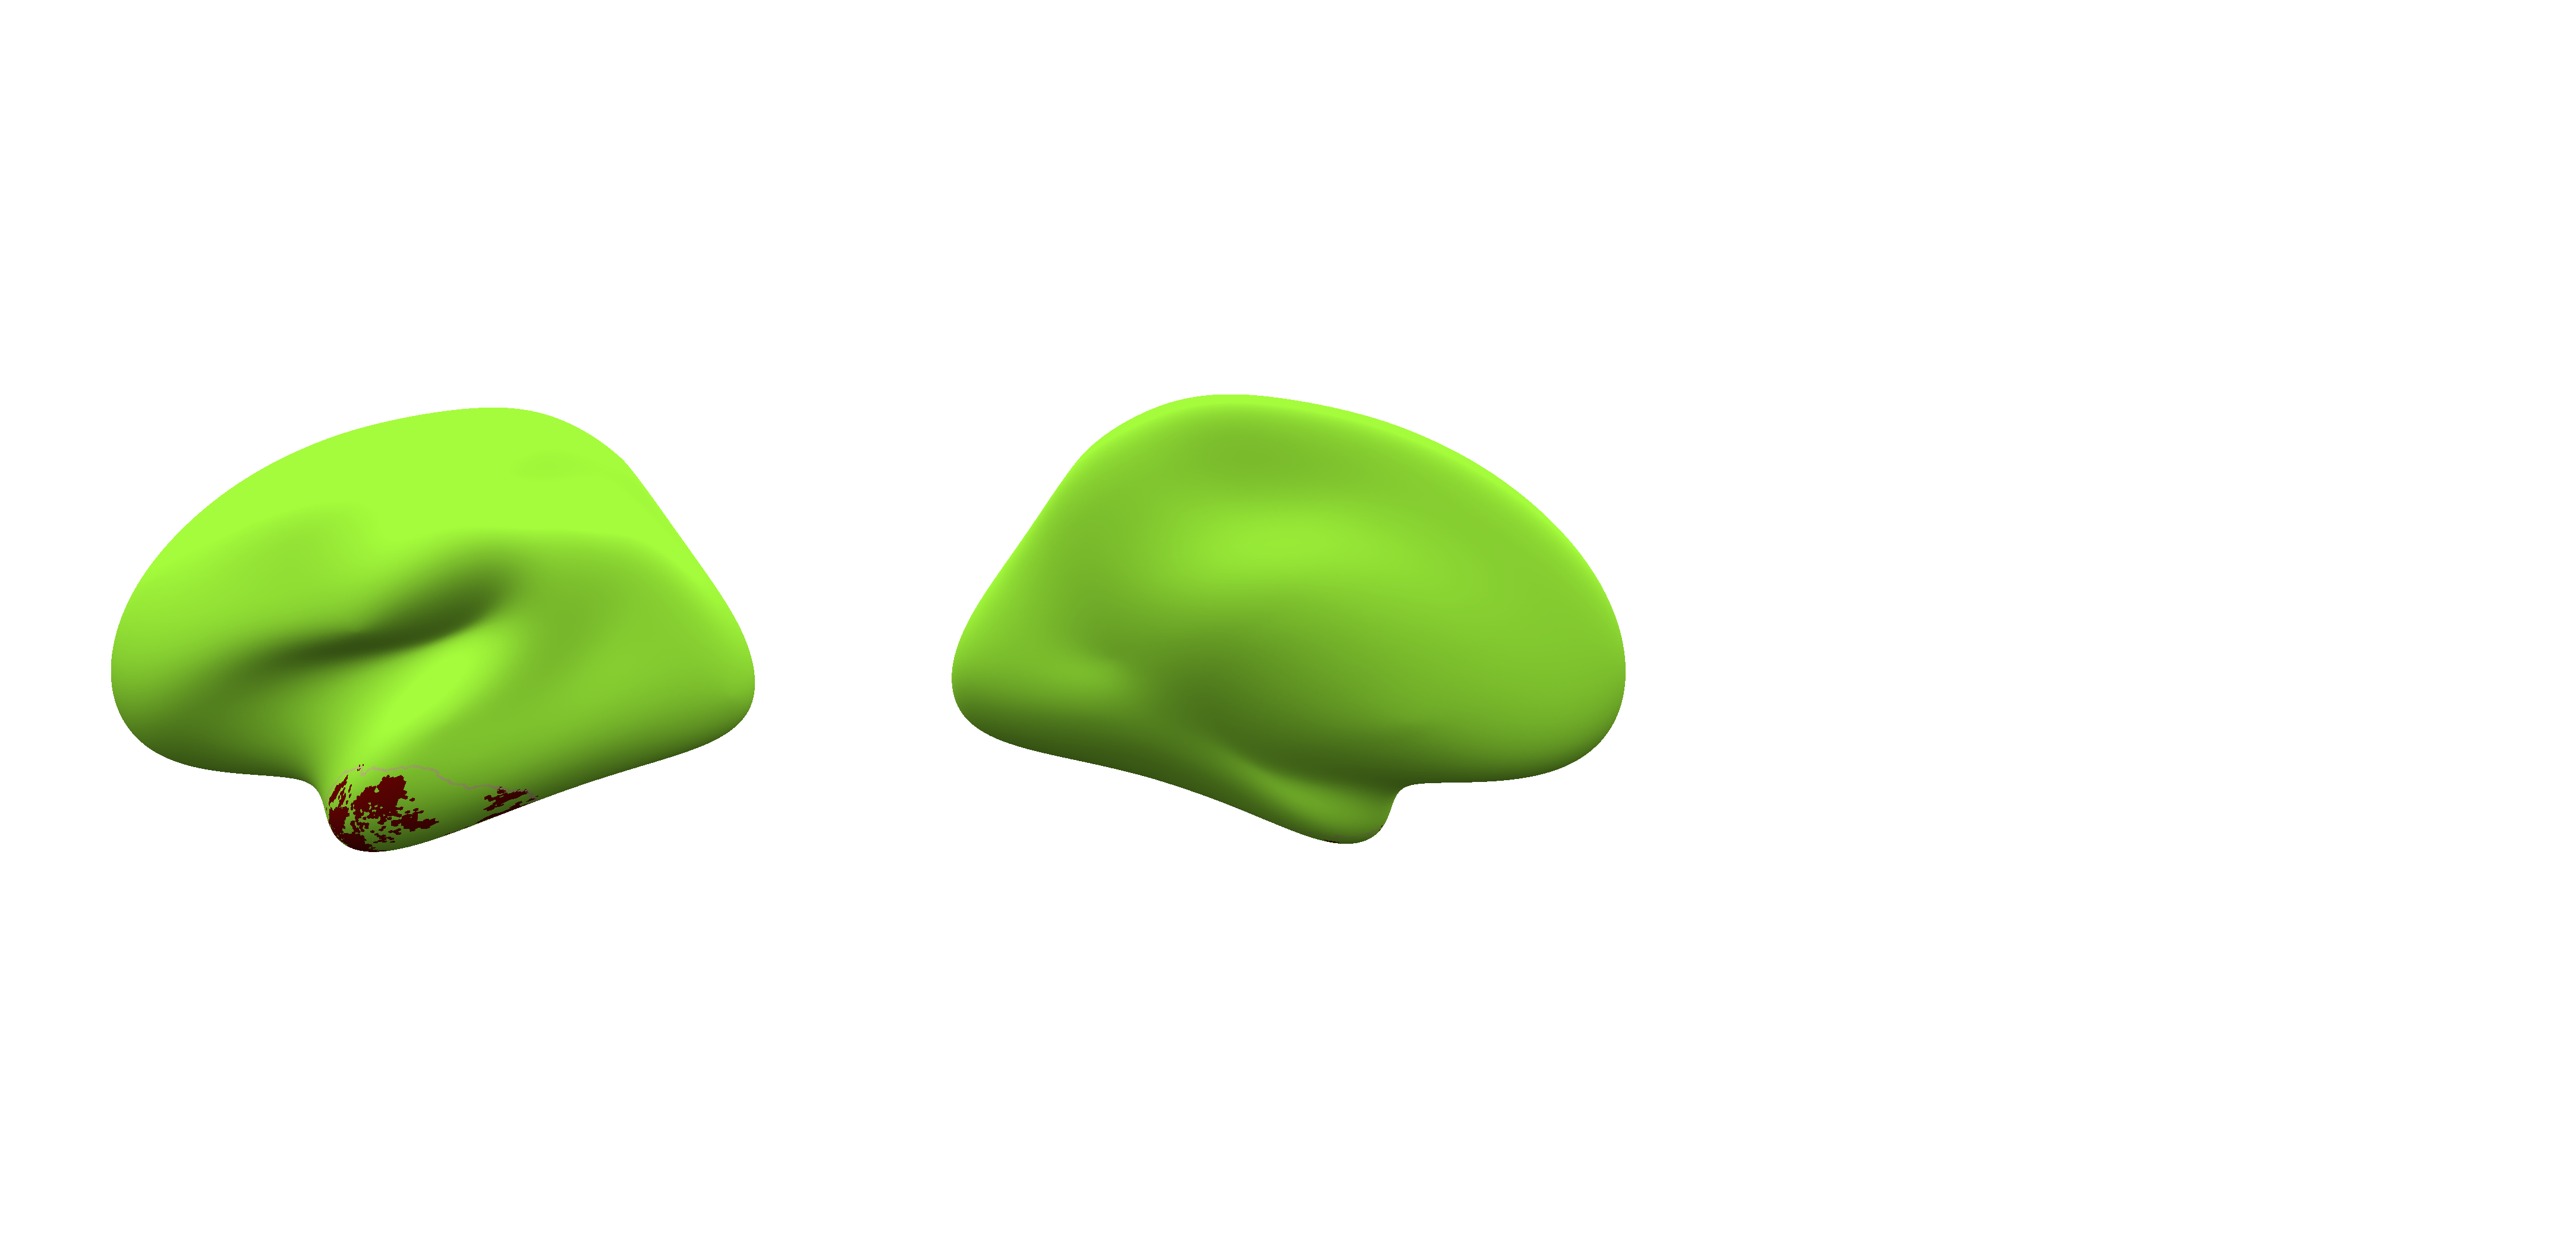

In [40]:
## extract most salient vertices
print(mask_clust.sum())

# aggregate features's saliencies
mean_saliencies = saliencies.mean(axis=1)

# find the vertices the most salient overall
thresh= np.percentile(mean_saliencies[mask_clust], 80)
vert_salient = (mean_saliencies>thresh)&mask_clust

# plot salient vertices
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], vert_salient,
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5, parcel = mask_clust,
    )

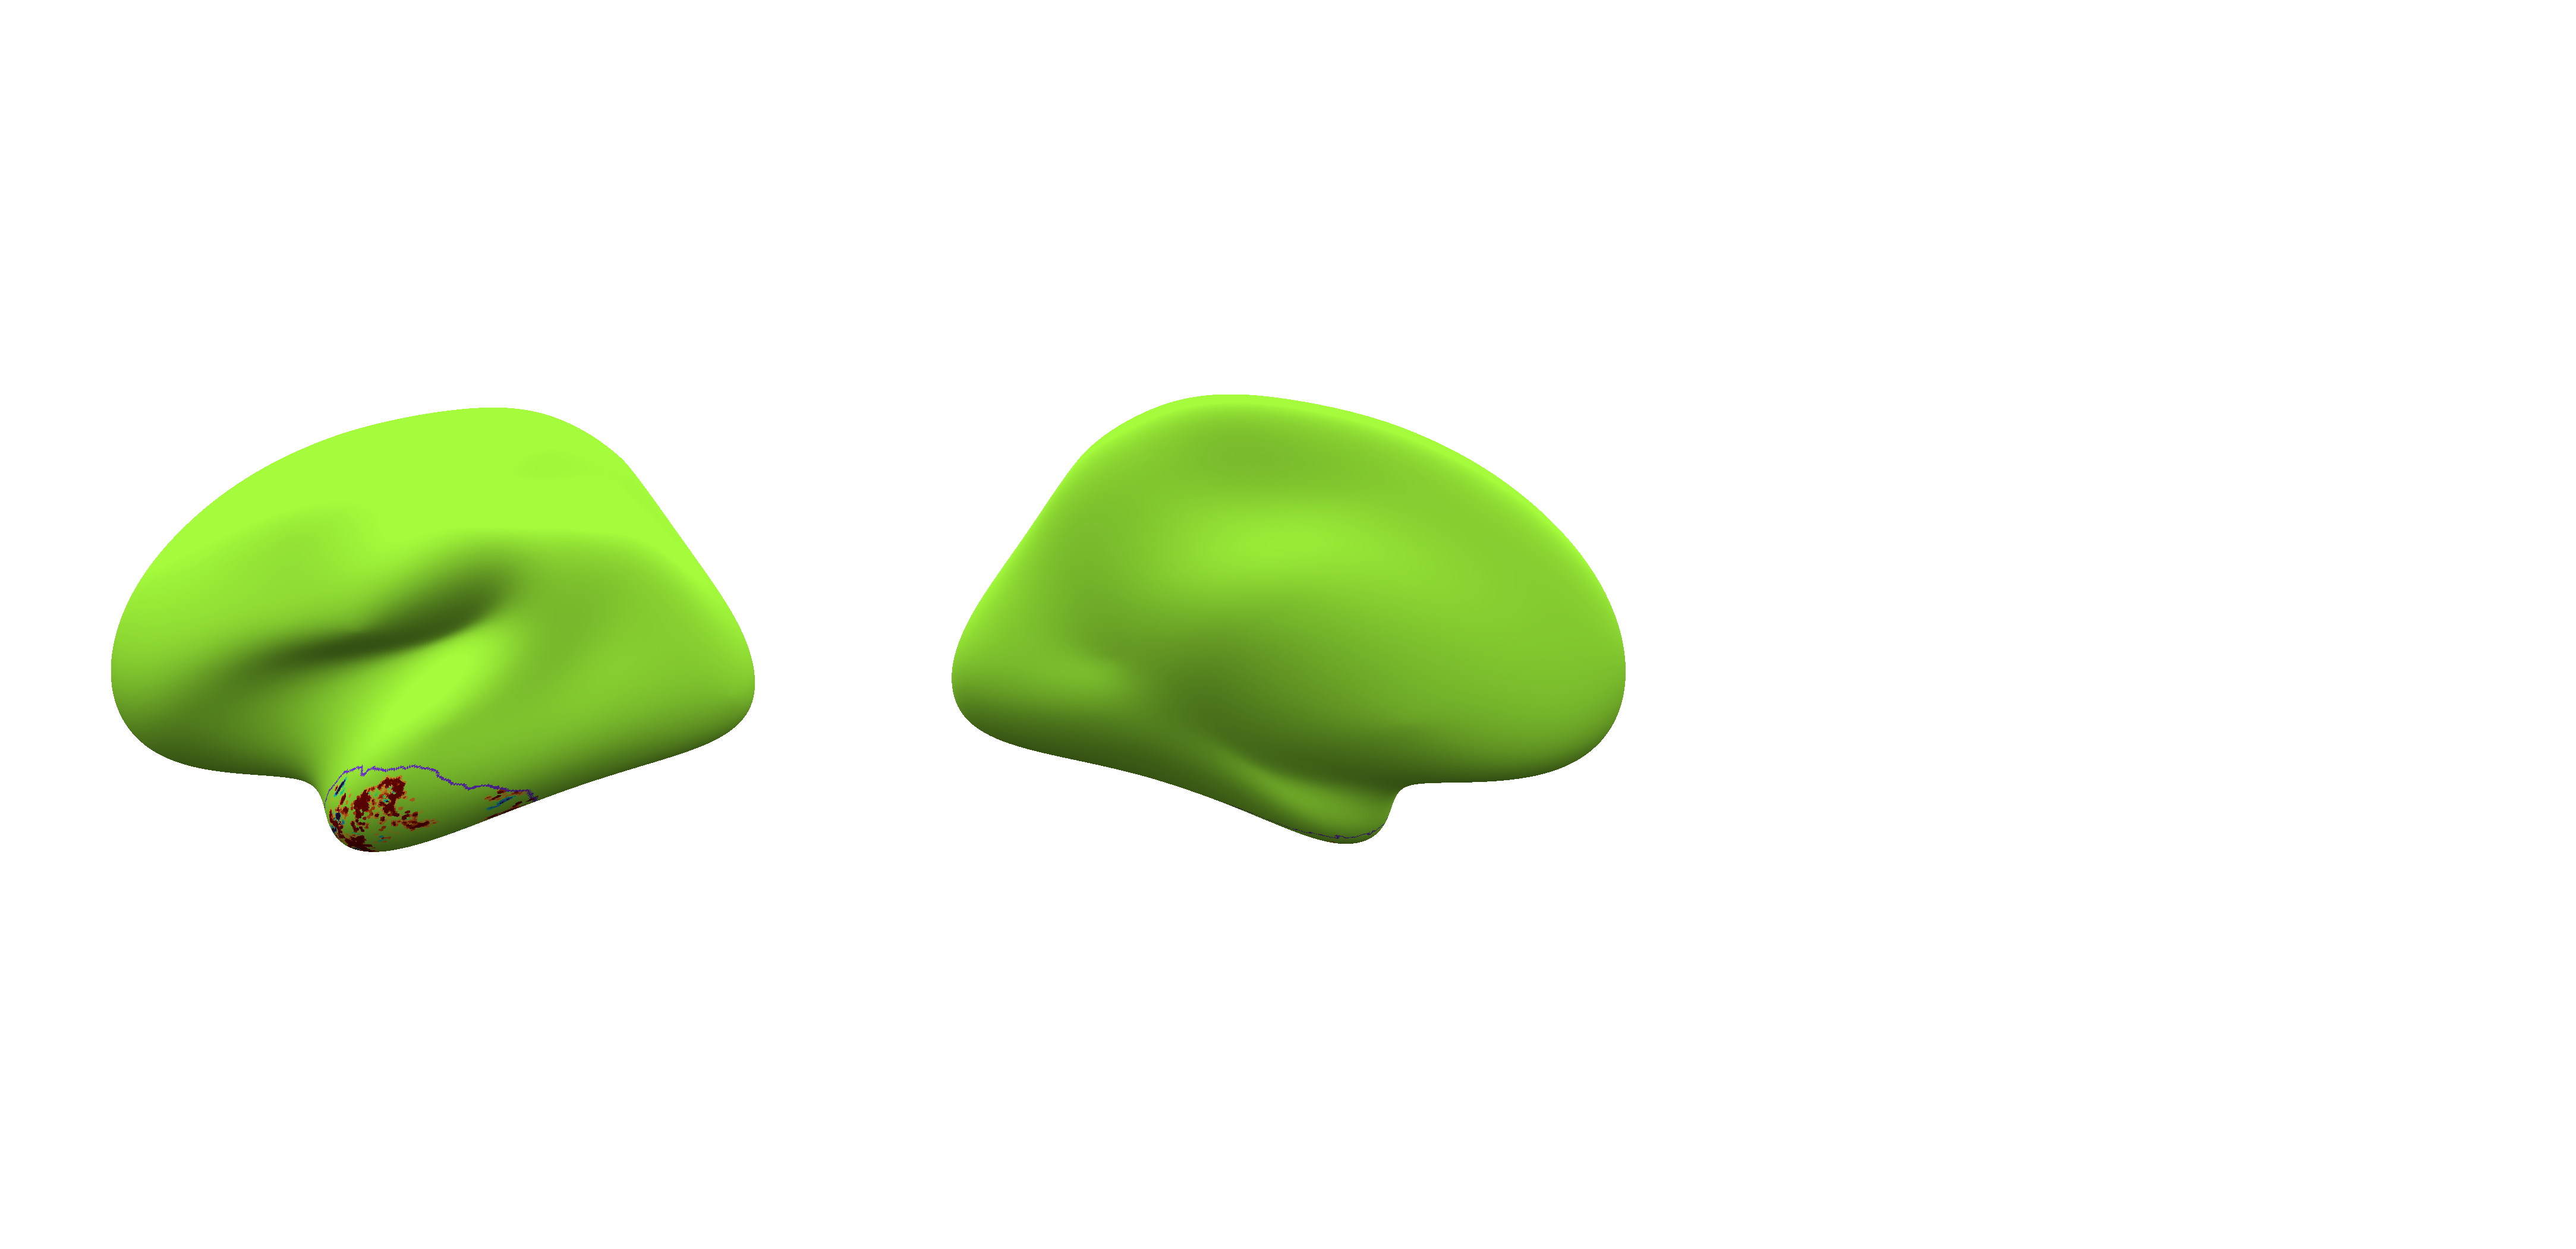

In [32]:
# plot saliencies feature restricted to salient vertices

overlay = saliencies.copy()
overlay[~mask_clust, :] = 0
overlay[~vert_salient, :] = 0

msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'], overlay[:,features.index(feature)],
    cmap='turbo',base_size = 30, colorbar=False, 
    vmin = -5e-5, vmax = 5e-5, parcel = mask_clust,
    )

## plot saliencies report

In [13]:
base_feature_set = [
        ".on_lh.gm_FLAIR_0.5.sm3.mgh",
        ".on_lh.wm_FLAIR_1.sm3.mgh",
        ".on_lh.curv.sm3.mgh",
        ".on_lh.pial.K_filtered.sm20.mgh",
        ".on_lh.sulc.sm3.mgh",
        ".on_lh.thickness_regression.sm3.mgh",
        ".on_lh.w-g.pct.sm3.mgh",
    ]

feature_names_set = [
        "GM FLAIR (50%)",
        "WM FLAIR (1mm)",
        "Mean curvature",
        "Intrinsic Curvature",
        "Sulcal depth",
        "Cortical thickness regressed",
        "Grey-white contrast",
    ]


In [14]:
subject_id = 'MELD_H14_3T_FCD_0017'

Loading and preprocessing test data
Z-scoring data for MELD_H14_3T_FCD_0017
saving mask_salient_1.0 for MELD_H14_3T_FCD_0017


1
6681


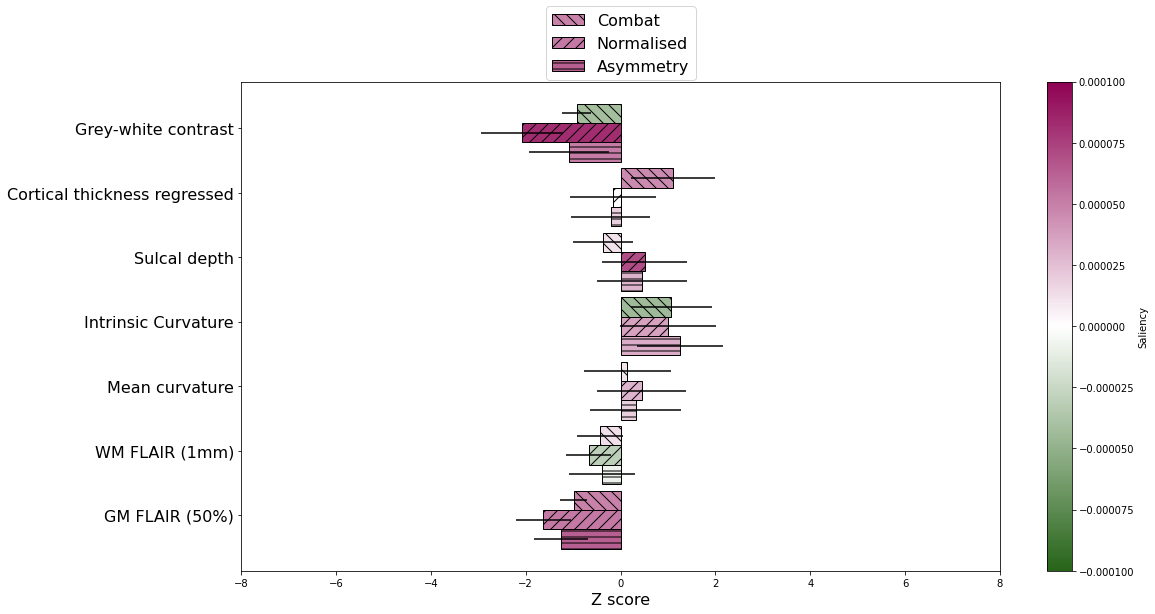

In [15]:
import matplotlib as mpl
import matplotlib.cm as cm

#load data for that subject
data_dictionary = eva.load_data_from_file(subject_id, keys=['cluster_thresholded','input_features'], 
                                          split_hemis=False, 
                                          save_prediction_suffix=save_prediction_suffix)
features_vals = data_dictionary['input_features']
predictions = data_dictionary['cluster_thresholded']

#check if subject has FLAIR
if features_vals[features.index('.combat.on_lh.gm_FLAIR_0.5.sm3.mgh')].sum()>0:
    base_features = base_feature_set
    feature_names = feature_names_set
else:
    base_features = base_feature_set[2:]
    feature_names = feature_names_set[2:]

#find clusters and load saliencies 
list_clust = set(predictions)
list_clust.remove(0.0)
saliencies_key = [f'saliencies_{cl}' for cl in list_clust]
saliencies = eva.load_data_from_file(subject_id, 
                                     keys=saliencies_key, 
                                     split_hemis=False, 
                                     save_prediction_suffix=save_prediction_suffix)
print(len(list_clust))

#initiate params for saliencies
prefixes = [".combat", ".inter_z.intra_z.combat", ".inter_z.asym.intra_z.combat"]
names = ["combat", "norm", "asym"]
lims = 1e-4
norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "grpr",
    colors=[
        "#276419",
        "#FFFFFF",
        "#8E0152",
    ],
)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
labels = ["Combat", "Normalised", "Asymmetry"]
hatching = ["\\\\", "//", "--"]


# loop over clusters
for cluster in list_clust:
    fig2 = plt.figure(figsize=(17, 9))
    ax2 = fig2.add_subplot()
    # get mask cluster
    mask = np.array([predictions == cluster])[0]
    # get mean saliencies
    saliencies_cl = saliencies[f'saliencies_{cluster}']
    mean_saliencies = saliencies_cl.mean(axis=1)
    # if cluster > 125 vertices, extract 20% most salient vertices
    size_clust = mask.sum()
    print(size_clust)
    if size_clust > 125:
        thresh= np.percentile(mean_saliencies[np.array(mask)], 80)
        mask = (mean_saliencies>thresh)
    # save mask salient vertices
    eva.save_prediction(
        subject_id,
        mask,
        dataset_str=f"mask_salient_{cluster}",
        suffix=save_prediction_suffix,
    ) 
    # plot saliencies
    for pr, prefix in enumerate(prefixes):
        cur_data = np.zeros(len(base_features))
        cur_err = np.zeros(len(base_features))
        saliency_data = np.zeros(len(base_features))
        for b, bf in enumerate(base_features):
            cur_data[b] = np.mean(
                            features_vals[mask, features.index(prefix + bf)]
                        )
            cur_err[b] = np.std(
                            features_vals[mask, features.index(prefix + bf)]
                        )
            saliency_data[b] = np.mean(
                            saliencies_cl[mask ,features.index(prefix + bf)]
                            )
        
        ax2.barh(
            y=np.array(range(len(base_features))) - pr * 0.3,
            width=cur_data,
            hatch=hatching[pr],
            height=0.3,
            edgecolor="k",
            xerr=cur_err,
            label=labels[pr],
            color=m.to_rgba(saliency_data),
        )
    ax2.set_xlim([-8, 8])
    ax2.set_yticks(np.array(range(len(base_features))) - 0.23)
    ax2.set_yticklabels(feature_names, fontsize=16)
    ax2.set_xlabel("Z score", fontsize=16)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17), fontsize=16)
    fig2.colorbar(m, label=f"Saliency", ax=ax2, )
    ax2.set_autoscale_on(True)

    # save plot
    images_dir = os.path.join(eva.save_dir,'images') 
    os.makedirs(images_dir, exist_ok=True)
    fig2.savefig(os.path.join(images_dir,f'{subject_id}_cl{cluster}_saliencies.png'))

In [16]:
eva.load_data_from_file(subject_id, 
                                     keys=['mask_salient_1.0'], 
                                     split_hemis=False, 
                                     save_prediction_suffix="")

{}